## Aprendizado Supervisionado
### prof. Duncan
Prática com Decision Tree Classifier e Iris

In [1]:
# fixar figuras no conteudo do notebook
%matplotlib inline
# pacotes básicos
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# pacotes do sklearn para acesso a datasets, preparação, modelagem e avaliação
from sklearn import datasets
#
# pacote para separação entre treino e teste
from sklearn.model_selection import train_test_split
#
# arsenal de preparação
from sklearn.preprocessing import MinMaxScaler # rescala em min-max
from sklearn.preprocessing import StandardScaler # padroniza features removendo média e
#     escalando para variância unitária. Também chamado de z-score
#
# pacote pipeline para combinar preparação e modelagem
from sklearn.pipeline import Pipeline, make_pipeline
#
# pacotes para validação cruzada
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
#
# pacotes de indução de modelos
from sklearn.tree import DecisionTreeClassifier
#
# pacotes para avaliação dos resultados
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.tree import plot_tree, export_graphviz, export_text

#pacotes para apoio a leitura e gravação de datasets
from pathlib import Path
import csv

#pacotes para visualização e formatação
import pprint
import graphviz
#
# configurações para os diferentes pacotes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# carga de dados
iris = datasets.load_iris(as_frame=True)
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [3]:
# separação em features e target
X = iris.data
y = iris.target
iris.frame

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
5,5.4,3.9,1.7,0.4,0
6,4.6,3.4,1.4,0.3,0
7,5.0,3.4,1.5,0.2,0
8,4.4,2.9,1.4,0.2,0
9,4.9,3.1,1.5,0.1,0


In [4]:
X.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


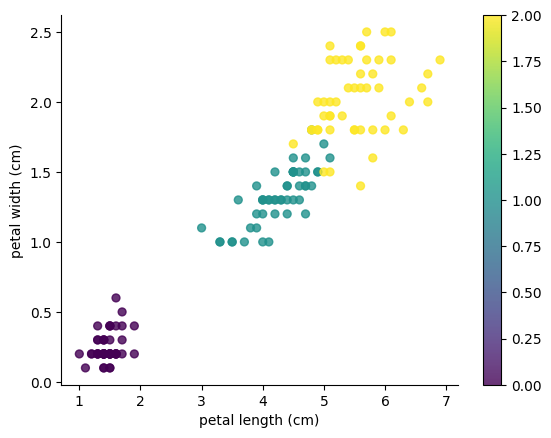

In [5]:
iris.frame[['petal length (cm)','petal width (cm)']].plot(kind='scatter',
                                                 x='petal length (cm)',
                                                 y='petal width (cm)',
                                                 s=32, alpha=.8,
                                                 c=y,
                                                 colormap='viridis')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [6]:
# separação em treino e teste, e X e y

treino_X, teste_X, treino_y, teste_y = train_test_split(X, y, random_state=0,test_size=0.2, stratify=y)

print(treino_X.shape)
print(treino_y.shape)
print(teste_X.shape)
print(teste_y.shape)
print(np.stack(np.unique(teste_y, return_counts=True), axis=1))

(120, 4)
(120,)
(30, 4)
(30,)
[[ 0 10]
 [ 1 10]
 [ 2 10]]


## Experimento com reescala de valores, embaralhamento e busca exaustiva nos parâmetros

In [7]:
# indução do modelo para diferentes valores para os parâmetros, com validação cruzada

#ccp_alphas = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 1.0, 10.0, 100.0]
ccp_alphas = [0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.04, 0.05, 0.055, 0.06, 0.07, 0.08, 0.09, 0.1]
#              0.11, 0.12, 0.13, 0.14, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
#ccp_alphas = [0.055]
#ccp_alphas = [0.0]
max_leafs = [2, 3, 4, 5, 6, 7, 8, 9]#, 10, 11, 13, 15, 17, 21]

k_splits = 10

modelo = Pipeline(steps=[('reescala', MinMaxScaler()),
    ('modelo', DecisionTreeClassifier(random_state=0))])

parametros = {'reescala__feature_range':[(0,1)],
              'modelo__ccp_alpha': ccp_alphas,
              'modelo__max_leaf_nodes':max_leafs,
              'modelo__criterion':['gini','entropy']}

skfold = StratifiedKFold(n_splits=k_splits, shuffle=True, random_state=0)

valcruz = GridSearchCV(modelo, parametros,cv=skfold)

valcruz.fit(treino_X, treino_y)

resultados = pd.DataFrame(valcruz.cv_results_).sort_values(by=['rank_test_score','param_modelo__max_leaf_nodes','param_modelo__ccp_alpha' ])
melhor_feature_range = resultados['param_reescala__feature_range'].iloc[0]
melhor_criterion = resultados['param_modelo__criterion'].iloc[0]
melhor_max_leaf_nodes = resultados['param_modelo__max_leaf_nodes'].iloc[0]
melhor_ccp_alpha = resultados['param_modelo__ccp_alpha'].iloc[0]

resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_modelo__ccp_alpha,param_modelo__criterion,param_modelo__max_leaf_nodes,param_reescala__feature_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
1,0.001853,0.000452,0.000754,0.000461,0.000,gini,3,"(0, 1)","{'modelo__ccp_alpha': 0.0, 'modelo__criterion'...",1.0,0.916667,0.916667,1.0,1.0,0.916667,0.916667,0.916667,1.0,1.0,0.958333,0.041667,1
9,0.001529,0.000511,0.000800,0.000400,0.000,entropy,3,"(0, 1)","{'modelo__ccp_alpha': 0.0, 'modelo__criterion'...",1.0,0.916667,0.916667,1.0,1.0,0.916667,0.916667,0.916667,1.0,1.0,0.958333,0.041667,1
17,0.002104,0.000667,0.000551,0.000472,0.005,gini,3,"(0, 1)","{'modelo__ccp_alpha': 0.005, 'modelo__criterio...",1.0,0.916667,0.916667,1.0,1.0,0.916667,0.916667,0.916667,1.0,1.0,0.958333,0.041667,1
25,0.001830,0.000472,0.000832,0.000313,0.005,entropy,3,"(0, 1)","{'modelo__ccp_alpha': 0.005, 'modelo__criterio...",1.0,0.916667,0.916667,1.0,1.0,0.916667,0.916667,0.916667,1.0,1.0,0.958333,0.041667,1
33,0.001873,0.000474,0.000940,0.000471,0.010,gini,3,"(0, 1)","{'modelo__ccp_alpha': 0.01, 'modelo__criterion...",1.0,0.916667,0.916667,1.0,1.0,0.916667,0.916667,0.916667,1.0,1.0,0.958333,0.041667,1


In [8]:
# listar os melhores resultados para os parâmetros

print('Melhor preparação - Feature Range:{}'.format(melhor_feature_range))
print('Melhor resultado - Critério:{}   Máximo número de nodos folha:{}   Alfa:{}    Acurácia média:{:.3f}'.format(
    melhor_criterion,
    melhor_max_leaf_nodes,
    melhor_ccp_alpha,
    resultados['mean_test_score'].iloc[0]))

Melhor preparação - Feature Range:(0, 1)
Melhor resultado - Critério:gini   Máximo número de nodos folha:3   Alfa:0.0    Acurácia média:0.958


## Execução para os melhores parâmetros

Acuracia=0.933


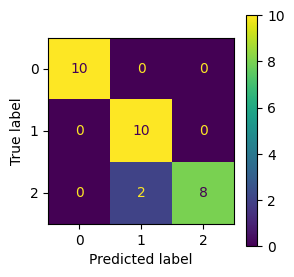

In [9]:
escalonador = MinMaxScaler(feature_range = melhor_feature_range)
estimador = DecisionTreeClassifier(ccp_alpha = melhor_ccp_alpha,
                                   max_leaf_nodes = melhor_max_leaf_nodes,
                                   criterion = melhor_criterion)
treino_X_escalonado = escalonador.fit_transform(treino_X, treino_y)
estimador.fit(treino_X_escalonado, treino_y)
teste_X_escalonado = escalonador.transform(teste_X)
teste_pred_y = estimador.predict(teste_X_escalonado)
acuracia = accuracy_score(teste_y, teste_pred_y)
resultado = confusion_matrix(teste_y, teste_pred_y)
cm_display = ConfusionMatrixDisplay(resultado).plot()
fig = cm_display.figure_
fig.set_figheight(3)
fig.set_figwidth(3)
print('Acuracia={:.3f}'.format(acuracia))

In [10]:
modelo_txt = export_text(estimador, feature_names=iris['feature_names'])
print(modelo_txt)

|--- petal width (cm) <= 0.29
|   |--- class: 0
|--- petal width (cm) >  0.29
|   |--- petal width (cm) <= 0.69
|   |   |--- class: 1
|   |--- petal width (cm) >  0.69
|   |   |--- class: 2



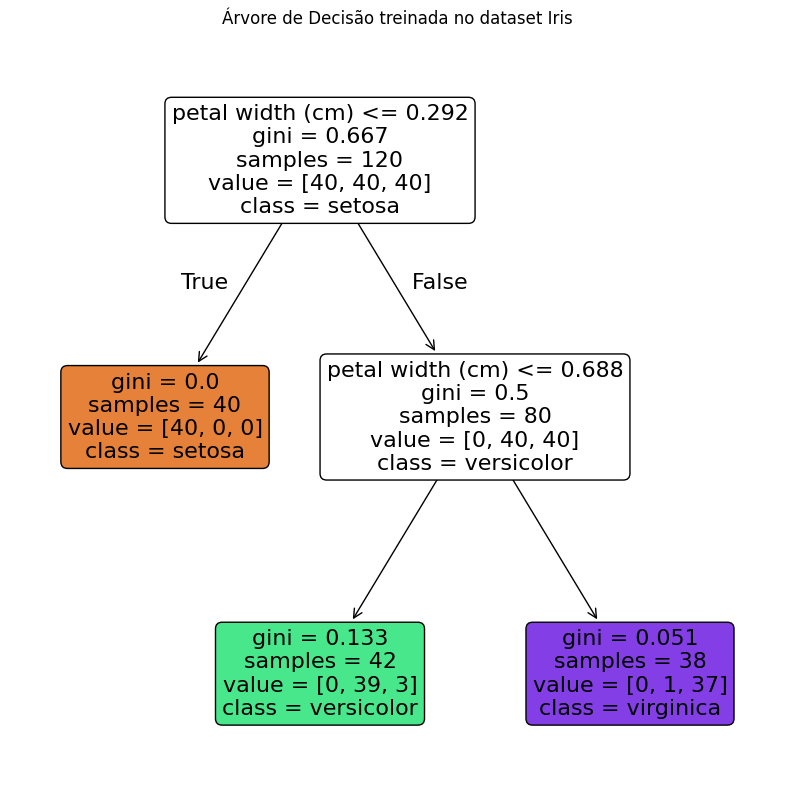

In [11]:
# apresentações do modelo
plt.figure(figsize=(10, 10))
plot_tree(estimador, filled=True, rounded=True, feature_names=iris.feature_names, class_names=iris.target_names)
plt.title('Árvore de Decisão treinada no dataset Iris')
plt.show()


## Mostra da distribuição de pontos e classes

In [12]:
treino_X_escalonado_DF = pd.DataFrame(treino_X_escalonado, columns=list(iris.feature_names))
X_mostra = treino_X_escalonado_DF[['petal length (cm)', 'petal width (cm)']].copy()

teste_X_escalonado_DF = pd.DataFrame(teste_X_escalonado, columns=list(iris.feature_names))
X_teste_mostra = teste_X_escalonado_DF[['petal length (cm)', 'petal width (cm)']].copy()


In [13]:
modelo_mostra = DecisionTreeClassifier(ccp_alpha = melhor_ccp_alpha,
                                   max_leaf_nodes = melhor_max_leaf_nodes,
                                   criterion = melhor_criterion)

modelo_mostra.fit(X_mostra, treino_y)

DecisionTreeClassifier(ccp_alpha=np.float64(0.0), max_leaf_nodes=np.int64(3))

In [14]:
modelo_txt = export_text(modelo_mostra, feature_names=['petal length (cm)', 'petal width (cm)'])
print(modelo_txt)

|--- petal width (cm) <= 0.29
|   |--- class: 0
|--- petal width (cm) >  0.29
|   |--- petal width (cm) <= 0.69
|   |   |--- class: 1
|   |--- petal width (cm) >  0.69
|   |   |--- class: 2



### Fundo e pontos a partir do treino

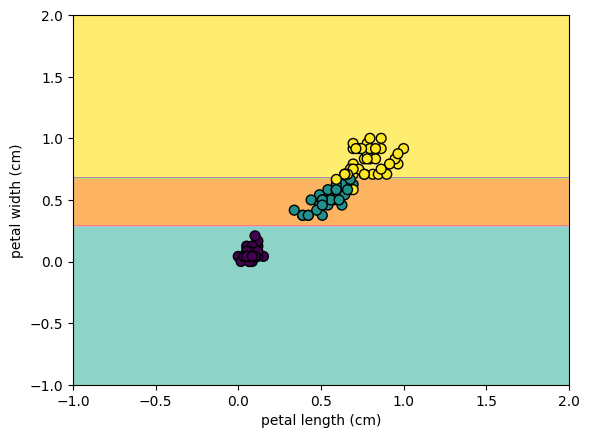

In [15]:
mostra = DecisionBoundaryDisplay.from_estimator(
    modelo_mostra,
    X_mostra,
    response_method="predict",
    cmap=plt.cm.Set3,
    xlabel='petal length (cm)',
    ylabel='petal width (cm)',
)
mostra.ax_.scatter(
    X_mostra['petal length (cm)'], X_mostra['petal width (cm)'], c=treino_y, s=50,
    cmap=plt.cm.viridis, edgecolor="black", linewidth=1
)

### Fundo a partir do treino e pontos a partir do teste

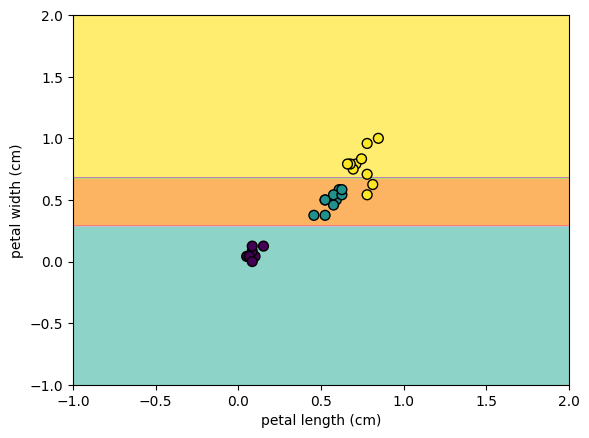

In [16]:
mostra = DecisionBoundaryDisplay.from_estimator(
    modelo_mostra,
    X_mostra,
    response_method="predict",
    cmap=plt.cm.Set3,
    xlabel='petal length (cm)',
    ylabel='petal width (cm)',
)
mostra.ax_.scatter(
    X_teste_mostra['petal length (cm)'], X_teste_mostra['petal width (cm)'], c=teste_y, s=50,
    cmap=plt.cm.viridis, edgecolor="black", linewidth=1
)